# Import Required Libraries
Import necessary libraries for data processing, regex pattern matching, transformer models, and visualization.

In [59]:
# Import Required Libraries

# Data processing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import torch
import json

# Regex pattern matching
import re

# Transformer models
from transformers import pipeline

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for plots
sns.set(style="whitegrid")

# Set defalt plt font size and typeface to times
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'Times New Roman'})

# Load and Prepare Data
Load the JSON file containing abstracts, extract the abstracts, and perform basic cleaning operations.

In [ ]:
# Load and Prepare Data

# Load the JSON file containing abstracts

with open("../data/02_document_search_results.json", "r") as file:
    data = json.load(file)

# Extract abstracts and DOIs from the JSON data
abstract_data = []
for entry in data:
    if "abstract" in entry:
        abstract_info = {
            "abstract": entry["abstract"],
            "doi": entry["doi"],
        }
        if "author_keywords" in entry:
            abstract_info["author_keywords"] = entry["author_keywords"]
        else:
            abstract_info["author_keywords"] = None  # Or some other default value
        abstract_data.append(abstract_info)


# Perform basic cleaning operations
def clean_text(text):
    # Remove newline characters
    text = text.replace("\n", " ")
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


# Clean the abstracts while keeping the DOI
cleaned_data = [
    {"abstract": clean_text(item["abstract"]), "doi": item["doi"], "author_keywords": item["author_keywords"]}
    for item in abstract_data
]

# Print count for verification
print(f"Total articles processed: {len(cleaned_data)}")

Total articles processed: 512


# Extract Descriptive Sentences
Use regex patterns to extract sentences containing phrases like 'This paper', 'This work', 'This study', etc. that describe the focus of the article.

In [ ]:
# Extract Descriptive Sentences with Expanded Patterns

# Define expanded regex patterns to match descriptive sentences
patterns = [
    r"\b[Tt]his (article|work|study|paper|research|review|survey|chapter)\b",
    r"\b[Ii]n this (work|study|paper|research|review|survey|chapter)\b",
    r"\b[Ww]e (propose|introduce|present|develop|describe|demonstrate|report|discuss|analyze|examine|investigate|explore|evaluate|address|outline)\b",
    r"\b[Ii]n this (manuscript|article|contribution|approach|framework|investigation|analysis|implementation)\b",
    r"\b[Tt]he (article|paper|study|work|research|review|survey|manuscript|current study|present study|present work|current work)\b",
    r"\b[Oo]ur (work|study|paper|chapter|research|approach|framework|method|system|contribution|focus|aim|objective|goal)\b",
    r"\b[Tt]his (manuscript|contribution|investigation|analysis|implementation|approach|framework|method|system)\b",
    r"\b[Tt]he (purpose|aim|goal|objective) of this (paper|work|study|research|article|chapter|manuscript)\b",
    r"\b[Hh]ere(,)? we\b",
]


def extract_text_from_pattern_to_end(text, patterns):
    """
    Extracts text from the first sentence matching any of the specified patterns
    until the end of the text (typically where authors start describing their specific work).

    If no pattern is found, returns an empty string.

    Args:
        text (str): The text to process
        patterns (list): List of regex patterns to match

    Returns:
        str: Text from the first pattern match to the end of the text, or empty string if no pattern is found
    """
    # Split text into sentences
    sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", text)

    # Find the index of the first sentence matching any pattern
    start_idx = -1
    for i, sentence in enumerate(sentences):
        if any(re.search(pattern, sentence) for pattern in patterns):
            start_idx = i
            break

    # If no pattern was found, return an empty string
    if start_idx == -1:
        return ""

    # Join the sentences from the matching sentence until the end
    result_text = " ".join(sentences[start_idx:])
    return result_text


# Add contribution text to the cleaned_data dictionary
for item in cleaned_data:
    item["contribution"] = extract_text_from_pattern_to_end(item["abstract"], patterns)

# Count abstracts with non-empty contributions
abstracts_with_contributions = [
    item for item in cleaned_data if item["contribution"].strip()
]

# Display statistics about extracted text segments
print(f"Number of abstracts processed: {len(cleaned_data)}")
print(
    f"Number of abstracts with contributions extracted: {len(abstracts_with_contributions)}"
)
print(
    f"Percentage with contributions extracted: {len(abstracts_with_contributions) / len(cleaned_data) * 100:.2f}%"
)
print(
    f"Average length of contributions: {sum(len(item['contribution']) for item in abstracts_with_contributions) / max(1, len(abstracts_with_contributions)):.2f} characters"
)

# Display the first few contribution texts (up to 500 chars) along with their DOIs
for i, item in enumerate(abstracts_with_contributions[:3]):
    print(f"Article {i+1} (DOI: {item['doi']}):")
    contribution = item["contribution"]
    print(f"{contribution[:500]}..." if len(contribution) > 500 else contribution)
    print("-" * 80)

# For backward compatibility, you can still create the list if needed
contribution_texts = [item["contribution"] for item in cleaned_data]
non_empty_contributions = [text for text in contribution_texts if text.strip()]

Number of abstracts processed: 512
Number of abstracts with contributions extracted: 458
Percentage with contributions extracted: 89.45%
Average length of contributions: 1021.56 characters
Article 1 (DOI: 10.1038/s41598-025-91206-6):
To address these issues, this study developed a multi-scale global perceptron network based on Transformer and CNN using novel encoder-decoders for enhancing contextual representation of buildings. Specifically, an improved multi-head-attention encoder is employed by constructing multi-scale tokens to enhance global semantic correlations. Meanwhile, the context refinement decoder is developed and synergistically uses high-level semantic representation and shallow features to restore spatial deta...
--------------------------------------------------------------------------------
Article 2 (DOI: 10.1016/j.ijcce.2024.12.003):
Purpose: This paper proposes a solution to address matching challenges, such as incomplete descriptions, reversed word order, and the d

In [ ]:
def extract_text_until_pattern(text, patterns):
    """
    Extracts text from the beginning of the abstract until it reaches a sentence
    that matches one of the specified patterns (typically where authors start
    describing their specific work).

    If no pattern is found, returns the entire text.

    Args:
        text (str): The text to process
        patterns (list): List of regex patterns to match

    Returns:
        str: Text until the first pattern match, or the entire text if no pattern is found
    """
    # Split text into sentences
    sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", text)

    # Collect sentences until a pattern match is found
    result_sentences = []
    pattern_found = False

    for sentence in sentences:
        # Check if sentence matches any pattern
        if any(re.search(pattern, sentence) for pattern in patterns):
            pattern_found = True
            break

        result_sentences.append(sentence)

    # If no pattern was found, return the original text
    if not pattern_found:
        return text

    # Join the collected sentences back together with spaces
    result_text = " ".join(result_sentences)
    return result_text


# Add introduction text to the cleaned_data dictionary
for item in cleaned_data:
    item["introduction"] = extract_text_until_pattern(item["abstract"], patterns)

# Count abstracts with non-empty introductions
abstracts_with_intros = [
    item for item in cleaned_data if item["introduction"].strip()
]
full_text_abstracts = [
    item for item in cleaned_data if item["introduction"] == item["abstract"]
]

# Display statistics about extracted introductory texts
print(f"Number of abstracts processed: {len(cleaned_data)}")
print(f"Number of abstracts with non-empty introductions: {len(abstracts_with_intros)}")
print(
    f"Percentage with non-empty introductions: {len(abstracts_with_intros) / len(cleaned_data) * 100:.2f}%"
)
print(
    f"Average length of non-empty introductions: {sum(len(item['introduction']) for item in abstracts_with_intros) / max(1, len(abstracts_with_intros)):.2f} characters"
)

# Statistics about abstracts where no pattern was found
print(f"Number of abstracts where no pattern was found: {len(full_text_abstracts)}")
print(
    f"Percentage with no pattern found: {len(full_text_abstracts) / len(cleaned_data) * 100:.2f}%"
)

# Display the first few introductory texts (up to 500 chars) along with their DOIs
for i, item in enumerate(abstracts_with_intros[:3]):
    print(f"\nIntroduction {i+1} (DOI: {item['doi']}):")
    intro = item["introduction"]
    print(f"{intro[:500]}..." if len(intro) > 500 else intro)
    print("-" * 80)

# For backward compatibility, you can still create the list if needed
intro_texts = [item["introduction"] for item in cleaned_data]
non_empty_intros = [text for text in intro_texts if text.strip()]

Number of abstracts processed: 512
Number of abstracts with non-empty introductions: 455
Percentage with non-empty introductions: 88.87%
Average length of non-empty introductions: 659.99 characters
Number of abstracts where no pattern was found: 54
Percentage with no pattern found: 10.55%

Introduction 1 (DOI: 10.1038/s41598-025-91206-6):
Building rooftop extraction has been applied in various fields, such as cartography, urban planning, automatic driving, and intelligent city construction. Automatic building detection and extraction algorithms using high spatial resolution aerial images can provide precise location and geometry information, significantly reducing time, costs, and labor. Recently, deep learning algorithms, especially convolution neural networks (CNNs) and Transformer, have robust local or global feature extractio...
--------------------------------------------------------------------------------

Introduction 2 (DOI: 10.1016/j.ijcce.2024.12.003):
Problem: Modernizing a

# Define Smart City Domains
Create a comprehensive dictionary of smart city domains (e.g., governance, mobility, safety, infrastructure, environment, healthcare) with detailed descriptions for each.

In [25]:
# Define Smart City Domains

# Read from a json file
with open('../data/config/smart_city_domains_extended.json', 'r') as f:
    smart_city_domains = json.load(f)

# Flatten the hierarchy into subdomain labels with their context
flattened_domains = {}
for main_domain, subdomains in smart_city_domains.items():
    for subdomain in subdomains:
        # Create a key-value pair where the subdomain is the key
        # and includes context about its parent domain
        flattened_domains[subdomain] = f"{subdomain} (part of {main_domain})"

# Create labels list from subdomains
labels = list(flattened_domains.keys())

# Build Transformer Model
Initialize a pre-trained transformer model (e.g., BERT, RoBERTa) and set up either a zero-shot classification approach or fine-tune the model if labeled data is available.

In [26]:
# Build Transformer Model for Zero-Shot Classification
# model = "facebook/bart-large-mnli"
model = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c"
# model = "MoritzLaurer/bge-m3-zeroshot-v2.0"


# Set tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check available devices
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())

# Set device for Apple Silicon
if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS (Metal Performance Shaders)")
elif torch.cuda.is_available():
    device = 0
    print("Using CUDA GPU")
else:
    device = -1
    print("Using CPU")


device = torch.device(device)

# Initialize the classifier with device setting
try:
    classifier = pipeline(
        "zero-shot-classification", model=model, device=device, multi_label=True
    )
    print("Classifier initialized successfully")
except Exception as e:
    print(f"Error initializing with {device}, falling back to CPU")
    device = -1
    classifier = pipeline(
        "zero-shot-classification", model=model, device=device, multi_label=True
    )

# Function to classify sentences into smart city domains
def classify_sentences(sentences, labels):
    results = []
    for sentence in tqdm(sentences):
        if sentence:  # Check if sentence is not empty
            try:
                result = classifier(
                    sentence,
                    candidate_labels=labels,
                    hypothesis_template="This text is about {}.",
                )
                results.append(result)
            except Exception as e:
                print(f"Error processing sentence: {str(e)}")
                results.append(None)
    return results

CUDA available: False
MPS available: True
Using MPS (Metal Performance Shaders)


Device set to use mps


Classifier initialized successfully


In [11]:
# Test with a single sentence first
test_sentence = "Fire detection has held stringent importance in computer vision for over half a century. The development of early fire detection strategies is pivotal to the realization of safe and smart cities, inhabitable in the future. However, the development of optimal fire and smoke detection models is hindered by limitations like publicly available datasets, lack of diversity, and class imbalance."
print("\nTesting single classification...")
test_result = classifier(
    test_sentence, candidate_labels=labels, multi_label=True, hypothesis_template="This text is about {}."
)
print("Test successful!")
print(f"Result: {test_result}")


Testing single classification...
Test successful!
Result: {'sequence': 'Fire detection has held stringent importance in computer vision for over half a century. The development of early fire detection strategies is pivotal to the realization of safe and smart cities, inhabitable in the future. However, the development of optimal fire and smoke detection models is hindered by limitations like publicly available datasets, lack of diversity, and class imbalance.', 'labels': ['Environment', 'Emergency Safety', 'Pollution Control', 'Public Policies', 'Public Services', 'Living', 'Innovation Policy', 'Cybersecurity', 'Buildings', 'Housing', 'Citizens', 'Resource Conservation', 'Green Spaces', 'Energy Management', 'Air Quality', 'Urban Planning', 'Sustainability', 'Smart Grids', 'Social Equity', 'Mobility', 'Pedestrian', 'Renewable Energy', 'Lightning', 'People', 'Transportation Systems', 'Learning and Teaching', 'Climate Change', 'Multimodal Transport', 'Healthcare', 'Citizen Engagement', '

In [ ]:
# Define a subset for testing (first 5 abstracts with non-empty introductions)
test_abstracts = [
    item for item in cleaned_data if item["introduction"].strip()
]

# Get all introductions at once
test_introductions = [item["introduction"] for item in test_abstracts]

# Process the test subset
print(f"\nClassifying introductions from {len(test_abstracts)} abstracts...")

# Classify all introductions at once
results = classify_sentences(test_introductions, labels)

# Store the results back in the original data structure
for i, item in enumerate(test_abstracts):
    item["classification_result"] = {
        "labels": results[i]["labels"],
        "scores": results[i]["scores"],
    }

# Display results summary
print(
    f"\nSuccessfully classified {len(results)} out of {len(test_abstracts)} introductions"
)


Classifying introductions from 455 abstracts...


100%|██████████| 455/455 [1:18:54<00:00, 10.41s/it]    


Successfully classified 455 out of 455 introductions


In [40]:
# Display example classifications
print("\nExample classifications:")
for i, item in enumerate(test_abstracts):
    print(f"\nAbstract {i+1} (DOI: {item['doi']}):")
    print(f"Introduction (truncated): {item['introduction'][:512]}...")
    print("Top 3 domains:")
    for label, score in zip(
        item["classification_result"]["labels"][:3],
        item["classification_result"]["scores"][:3],
    ):
        print(f"  - {label}: {score:.4f}")


Example classifications:

Abstract 1 (DOI: 10.1038/s41598-025-91206-6):
Introduction (truncated): Building rooftop extraction has been applied in various fields, such as cartography, urban planning, automatic driving, and intelligent city construction. Automatic building detection and extraction algorithms using high spatial resolution aerial images can provide precise location and geometry information, significantly reducing time, costs, and labor. Recently, deep learning algorithms, especially convolution neural networks (CNNs) and Transformer, have robust local or global feature extraction ability, a...
Top 3 domains:
  - Buildings: 0.9833
  - Environment: 0.1095
  - Urban Planning: 0.0087

Abstract 2 (DOI: 10.1016/j.ijcce.2024.12.003):
Introduction (truncated): Problem: Modernizing and standardizing place names and addresses is a key challenge in the development of smart cities....
Top 3 domains:
  - Governance: 0.6887
  - Urban Planning: 0.1542
  - Public Policies: 0.0668

Abstra

# Evaluate Results


## Evaluate statistics of scores to determine the threshold

In [ ]:
# Extract the statistics for the scores

# Extract the scores for each domain
domain_scores = {domain: [] for domain in labels}
for abstract in test_abstracts:
    if "classification_result" in abstract:
        # Get the top 3 labels and scores
        top_labels = abstract["classification_result"]["labels"][:5]
        top_scores = abstract["classification_result"]["scores"][:5]

        for label, score in zip(top_labels, top_scores):
            domain_scores[label].append(score)

# Display the average scores for each domain
print("\n📊 Average Scores per Domain:")

# Calculate the average score for each domain
average_scores = {domain: np.mean(scores) for domain, scores in domain_scores.items()}
for domain, score in sorted(average_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {domain}: {score:.4f}")

# Find the maximum length of score lists
max_len = max(len(scores) for scores in domain_scores.values())

# Pad shorter lists with NaN values
for domain, scores in domain_scores.items():
    while len(scores) < max_len:
        scores.append(np.nan)

# Plot the distribution of scores for each domain
plt.figure(figsize=(12, 6))
sns.violinplot(data=pd.DataFrame(domain_scores))
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Classification Scores for Smart City Domains")
plt.ylabel("Score")
plt.xlabel("Smart City Domain")
plt.tight_layout()
plt.show()


📏 Possible Thresholds:
  - fixed_conservative: 0.5000
  - fixed_liberal: 0.3000
  - mean: 0.3210
  - median: 0.1152
  - percentile_25: 0.0242
  - percentile_75: 0.6410
  - mean_minus_std: -0.0434

📊 Domains Assigned per Abstract with Different Thresholds:
  - fixed_conservative (threshold=0.5000): 1.53 domains per abstract
  - fixed_liberal (threshold=0.3000): 1.95 domains per abstract
  - mean (threshold=0.3210): 1.90 domains per abstract
  - median (threshold=0.1152): 2.92 domains per abstract
  - percentile_25 (threshold=0.0242): 5.51 domains per abstract
  - percentile_75 (threshold=0.6410): 1.26 domains per abstract
  - mean_minus_std (threshold=-0.0434): 49.00 domains per abstract


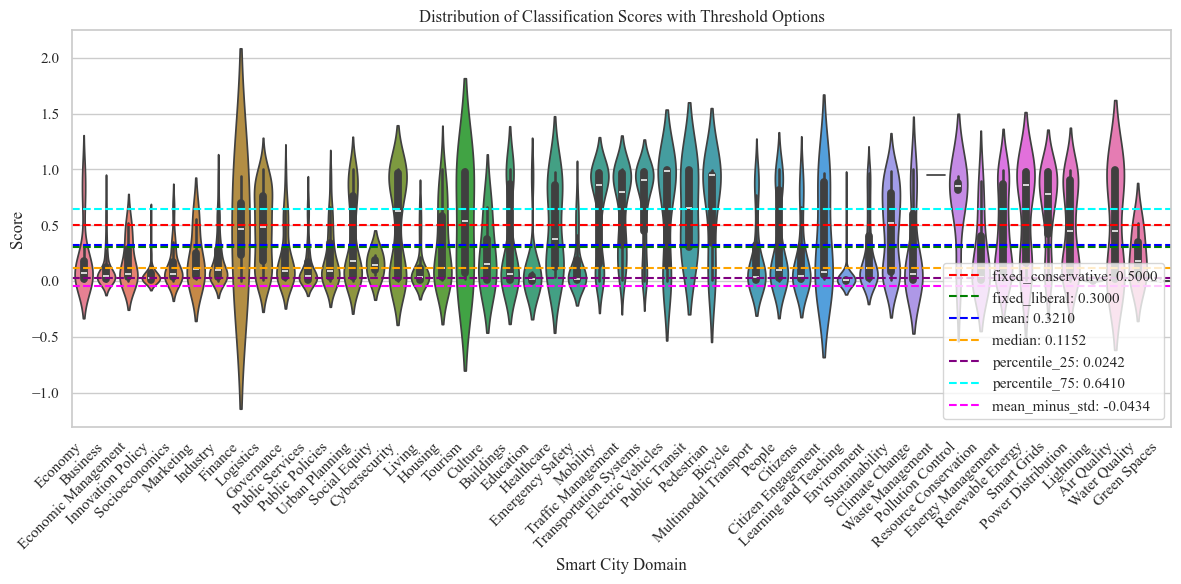

In [60]:
# Calculate statistical thresholds
all_scores = []
for scores in domain_scores.values():
    all_scores.extend([s for s in scores if not np.isnan(s)])

# Calculate various statistical thresholds
thresholds = {
    "fixed_conservative": 0.5,  # Standard fixed threshold
    "fixed_liberal": 0.3,  # More inclusive fixed threshold
    "mean": np.mean(all_scores),  # Average of all scores
    "median": np.median(all_scores),  # Median (50th percentile)
    "percentile_25": np.percentile(all_scores, 25),  # 25th percentile
    "percentile_75": np.percentile(all_scores, 75),  # 75th percentile
    "mean_minus_std": np.mean(all_scores)
    - np.std(all_scores),  # Lower statistical bound
}

# Display calculated thresholds
print("\n📏 Possible Thresholds:")
for name, value in thresholds.items():
    print(f"  - {name}: {value:.4f}")

# Let's see how many domains would be assigned with each threshold
print("\n📊 Domains Assigned per Abstract with Different Thresholds:")
for name, threshold in thresholds.items():
    domains_per_abstract = []
    for abstract in test_abstracts:
        if "classification_result" in abstract:
            assigned_domains = sum(
                1
                for score in abstract["classification_result"]["scores"]
                if score >= threshold
            )
            domains_per_abstract.append(assigned_domains)

    avg_domains = np.mean(domains_per_abstract) if domains_per_abstract else 0
    print(
        f"  - {name} (threshold={threshold:.4f}): {avg_domains:.2f} domains per abstract"
    )

# Plot threshold lines on the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=pd.DataFrame(domain_scores))
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Classification Scores with Threshold Options")
plt.ylabel("Score")
plt.xlabel("Smart City Domain")

# Add horizontal lines for thresholds with different colors
colors = ["red", "green", "blue", "orange", "purple", "cyan", "magenta"]
for (name, value), color in zip(thresholds.items(), colors):
    plt.axhline(y=value, color=color, linestyle="--", label=f"{name}: {value:.4f}")

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Assign Macro Smart City Domains

In [61]:
from collections import Counter

def assign_macro_domains(abstracts, domain_hierarchy, score_threshold=0.5):
    """
    Assigns each abstract to one or more macro smart city domains based on
    classification scores that exceed a threshold.

    Args:
        abstracts (list): List of abstract dictionaries with classification results
        domain_hierarchy (dict): Smart city domains hierarchy dictionary
        score_threshold (float): Minimum score to assign a domain (default: 0.5)

    Returns:
        list: The same abstracts list with macro_domains added to each entry
    """
    # Create a mapping from subdomain to parent domain
    subdomain_to_macro = {}
    for macro_domain, subdomains in domain_hierarchy.items():
        for subdomain in subdomains:
            subdomain_to_macro[subdomain.lower()] = macro_domain

    # Process each abstract
    for abstract in abstracts:
        # Skip if no classification result
        if "classification_result" not in abstract:
            abstract["macro_domains"] = []
            continue

        # Get classification results
        labels = abstract["classification_result"]["labels"]
        scores = abstract["classification_result"]["scores"]

        # Initialize domain scores dictionary
        domain_scores = {macro: 0.0 for macro in domain_hierarchy.keys()}

        # Aggregate scores by macro domain
        for label, score in zip(labels, scores):
            label_lower = label.lower()
            # Find the macro domain for this label
            for subdomain, macro_domain in subdomain_to_macro.items():
                if subdomain in label_lower:
                    # Take the highest score for each macro domain
                    domain_scores[macro_domain] = max(
                        domain_scores[macro_domain], score
                    )
                    break

        # Filter domains by threshold and sort by score
        macro_domains = [
            {"domain": domain, "score": score}
            for domain, score in domain_scores.items()
            if score >= score_threshold
        ]

        # Sort by score in descending order
        macro_domains.sort(key=lambda x: x["score"], reverse=True)

        # Add to abstract
        abstract["macro_domains"] = macro_domains

    return abstracts


# Apply the function to test abstracts
assign_macro_domains(test_abstracts, smart_city_domains, score_threshold=0.45)

# Get statistics on domain distribution
if test_abstracts:
    all_domains = []
    for abstract in test_abstracts:
        if "macro_domains" in abstract:
            all_domains.extend([d["domain"] for d in abstract["macro_domains"]])

    domain_counts = Counter(all_domains)

    print("\n📊 Domain Distribution:")
    for domain, count in domain_counts.most_common():
        print(f"  - {domain}: {count} abstracts")

    print(f"\nAverage domains per abstract: {len(all_domains)/len(test_abstracts):.2f}")

    # Count abstracts with multiple domains
    multi_domain_count = sum(
        1
        for abstract in test_abstracts
        if "macro_domains" in abstract and len(abstract["macro_domains"]) > 1
    )
    print(
        f"Abstracts with multiple domains: {multi_domain_count} ({multi_domain_count/len(test_abstracts)*100:.2f}%)"
    )


📊 Domain Distribution:
  - Smart Mobility: 117 abstracts
  - Smart Governance: 103 abstracts
  - Smart Environment: 99 abstracts
  - Smart Economy: 79 abstracts
  - Smart Living: 41 abstracts
  - Smart People: 29 abstracts

Average domains per abstract: 1.03
Abstracts with multiple domains: 117 (25.71%)


# Visualize Domain Distribution
Create visualizations (e.g., bar charts, word clouds) to display the distribution of smart city domains in the dataset and highlight key terms associated with each domain.

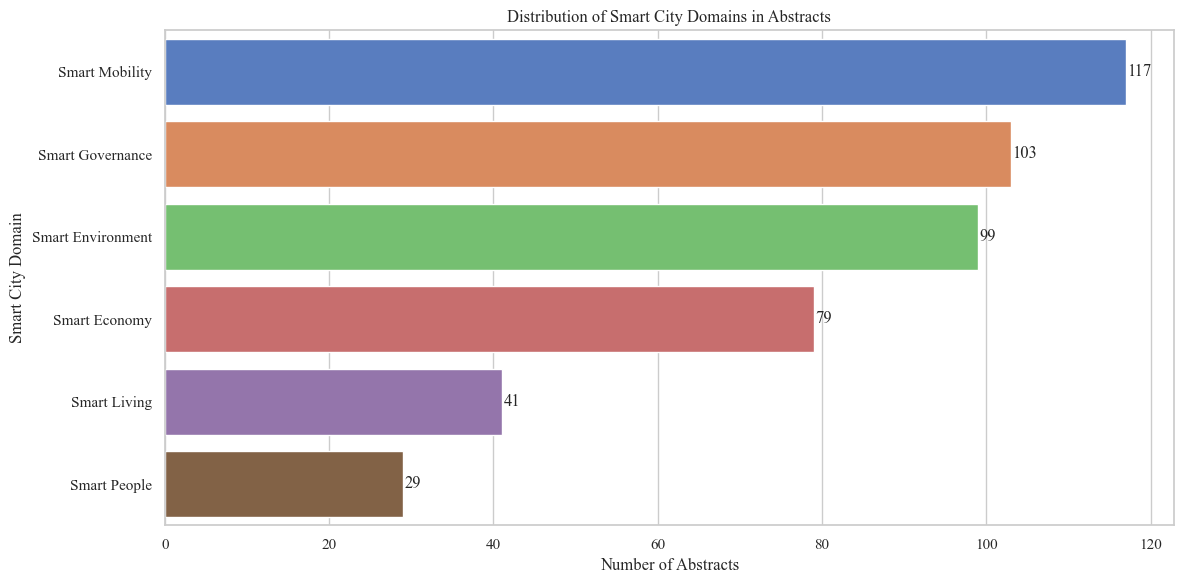

In [62]:
# Plot the distribution of domains using a matte color palette
palette = sns.color_palette("muted", n_colors=len(domain_counts))

# Create the domain and count lists
domains = [domain for domain, count in domain_counts.most_common()]
counts = [count for domain, count in domain_counts.most_common()]

# Create a bar plot of domain counts with the correct parameter structure
plt.figure(figsize=(12, 6))
sns.barplot(
    x=counts,
    y=domains,
    hue=domains,  # Add this parameter
    palette=palette,
    legend=False,  # Add this parameter
)
plt.xlabel("Number of Abstracts")
plt.ylabel("Smart City Domain")
plt.title("Distribution of Smart City Domains in Abstracts")

# Add value labels to the end of each bar
for i, count in enumerate(counts):
    plt.text(count + 0.2, i, str(count), va="center")

# Adjust layout and margins
plt.tight_layout()

# Save the plot
# plt.savefig("../data/03_domain_distribution.png")

# Display the plot
plt.show()

In [ ]:
# Print results for articles with no assigned domains
no_domain_abstracts = [a for a in test_abstracts if not a["macro_domains"]]
print(f"\n{len(no_domain_abstracts)} articles with no assigned domains:")
for abstract in no_domain_abstracts:
    print(f"  - {abstract['doi']}")
    print(f"    {abstract['introduction'][:200]}...")
    print()


145 articles with no assigned domains:
  - 10.1016/j.ipm.2025.104107
    Distributed multivariate time series anomaly detection is widely-used in industrial equipment monitoring, financial risk management, and smart cities. Although Federated learning (FL) has garnered sig...

  - 10.1007/s10462-024-11092-8
    Crowd anomaly detection is one of the most popular topics in computer vision in the context of smart cities. A plethora of deep learning methods have been proposed that generally outperform other mach...

  - 10.1111/exsy.70001
    Point-of-interest (POI) extraction aims to extract text POIs from real-world data. Existing POI methods, such as social media-based user generating and web crawling, either require massive human resou...

  - 10.1016/j.engstruct.2024.119472
    The intelligent design of shear wall structures is a critical aspect of smart construction, with a high demand for research and applications. Accurately predicting the shear wall ratio (i.e., the shea...

  - 

# Save the Data

In [58]:
import json
import os

# Create a timestamp for the filename
output_directory = "../data/"
output_filename = "06_classified_abstracts_smart_domains.json"
output_path = os.path.join(output_directory, output_filename)

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

try:
    # Convert any non-serializable objects (like numpy arrays or tensors) to standard Python types
    serializable_abstracts = []
    for abstract in test_abstracts:
        # Create a copy of the abstract to avoid modifying the original
        abstract_copy = abstract.copy()

        # Handle any potential non-serializable data
        if "classification_result" in abstract_copy:
            scores = abstract_copy["classification_result"]["scores"]
            # Convert numpy arrays or tensors to lists if necessary
            if not isinstance(scores, list):
                abstract_copy["classification_result"]["scores"] = (
                    scores.tolist() if hasattr(scores, "tolist") else list(scores)
                )

        # Handle macro_domains if present
        if "macro_domains" in abstract_copy:
            for domain_info in abstract_copy["macro_domains"]:
                if not isinstance(domain_info["score"], (int, float)):
                    domain_info["score"] = float(domain_info["score"])

        serializable_abstracts.append(abstract_copy)

    # Write to JSON file with proper formatting
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(serializable_abstracts, f, indent=2, ensure_ascii=False)

    print(
        f"✅ Successfully saved {len(serializable_abstracts)} classified abstracts to:"
    )
    print(f"   {output_path}")

except Exception as e:
    print(f"❌ Error saving abstracts to JSON: {str(e)}")

✅ Successfully saved 455 classified abstracts to:
   ../data/06_classified_abstracts_smart_domains.json
